In [ ]:

#------importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import *
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau,CSVLogger
from tqdm.notebook import tqdm
import tensorflow as tf
from keras.layers import *
from keras.models import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report
import shutil




In [ ]:

#---------Data Read & Transformation---------

#Data Reading for Davidson Dataset
nRowsRead = None # specify 'None' to read complete file
df0 = pd.read_csv("/content/drive/MyDrive/CSE438/dataset/labeled_data.csv", delimiter=',', nrows = nRowsRead)
nRow, nCol = df0.shape
print('There are {} rows and {} columns'.format(nRow, nCol))


There are 24783 rows and 7 columns


In [ ]:

#Doing Transformation
c=df0['class']
df0.rename(columns={'tweet' : 'text',
                   'class' : 'category'},
                    inplace=True)
a=df0['text']
b=df0['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})
df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'},
                    inplace=True)

hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

x= df['text']
y=df['label']

texts = x
target = y


Examples:
    Total: 24783
    hate: 1430 (5.77% of total)

Examples:
    Total: 24783
    Ofensive: 19190 (77.43% of total)

Examples:
    Total: 24783
    Neither: 4163 (16.80% of total)



In [ ]:
#tokensing the data

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)



In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#defining vocabulary length
vocab_length = len(word_tokenizer.word_index) + 1

def embed(text_data):
    return word_tokenizer.texts_to_sequences(text_data)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))




In [ ]:
#padding_data
train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)

embeddings_dictionary = dict()
embedding_dim = 100

In [ ]:

# Loading GloVe-100D embedding_file
with open('/content/drive/MyDrive/CSE438/dataset/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

# Loading embedding_vectors of words which comes in Glove files other will be equated to 0
#defining embedding matrix shape
embedding_matrix = np.zeros((vocab_length, embedding_dim))
#creating embedding matrix
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.25
)

X_train, x_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1 )


In [ ]:


#defining glove bilstm model
def bilstm():
    model = Sequential()
    #adding embediing layer
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence))
    #adding Bi_lstm later
    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D()) #globalmaxpooling_layer
    model.add(BatchNormalization()) #bath_normalisation
    model.add(Dropout(0.5)) #dropout_1
    model.add(Dense(length_long_sentence, activation = "relu")) #denselayer_1
    model.add(Dropout(0.5)) #dropout_2
    model.add(Dense(length_long_sentence, activation = "relu")) #denselayer_2
    model.add(Dropout(0.5)) #dropout_3
    model.add(Dense(3, activation = 'softmax')) #classification_layer
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

bilstm_model = bilstm()

In [ ]:
#defining_class_weight for each class
weight_class1 = (1 / hate)*(total)/3.0
weight_class2 = (1 / ofensive)*(total)/3.0
weight_class3 = (1 / neither)*(total)/3.0
class_weight = {0: weight_class1, 1: weight_class2, 2: weight_class3}


reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)

epoch_count=20
batch_size= 128

In [ ]:

#running_model
history = bilstm_model.fit(
    X_train,
    y_train,
    epochs = epoch_count,
    batch_size = batch_size,
    validation_data = (x_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr],
    class_weight=class_weight
)


Epoch 1/20
131/131 [==============================] - 339s 3s/step - loss: 1.1297 - accuracy: 0.5206 - val_loss: 0.8970 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 319s 2s/step - loss: 0.7057 - accuracy: 0.7220 - val_loss: 0.7672 - val_accuracy: 0.7951 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 314s 2s/step - loss: 0.5579 - accuracy: 0.7685 - val_loss: 0.4994 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 314s 2s/step - loss: 0.4915 - accuracy: 0.7915 - val_loss: 0.5869 - val_accuracy: 0.7219 - lr: 0.0010
Epoch 5/20
131/131 [==============================] - 311s 2s/step - loss: 0.4247 - accuracy: 0.8072 - val_loss: 0.3247 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 6/20
131/131 [==============================] - 324s 2s/step - loss: 0.3501 - accuracy: 0.8211 - val_loss: 0.3230 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 7/20
131/131 [==============================] - 313s 2s/st

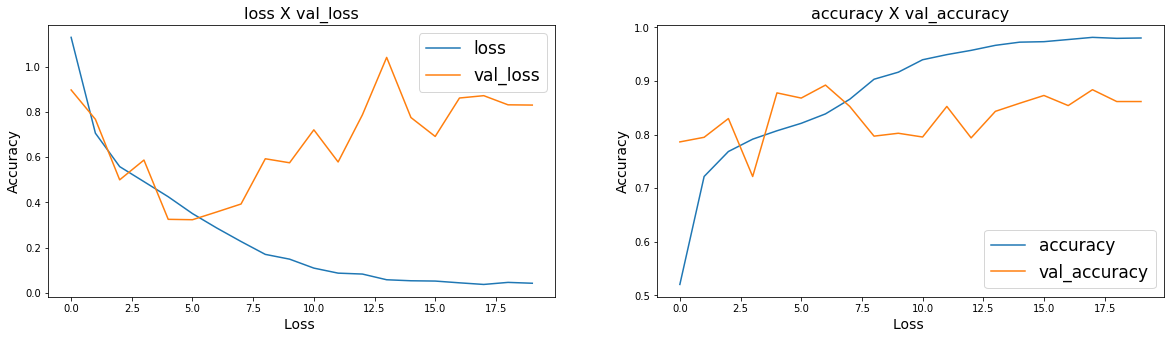

In [ ]:
#plotting graphs
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=17)
        ax[idx].set_xlabel('Loss ',fontsize=14)
        ax[idx].set_ylabel('Accuracy',fontsize=14)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:
#prediciting
preds= np.argmax(bilstm_model.predict(X_test), axis=-1)
#printing classification_report & confusion_matrix
print(classification_report(y_test,preds ))
print(confusion_matrix(y_test, preds))

194/194 [==============================] - 40s 203ms/step
              precision    recall  f1-score   support

           0       0.27      0.49      0.35       349
           1       0.94      0.88      0.91      4786
           2       0.82      0.84      0.83      1061

    accuracy                           0.85      6196
   macro avg       0.68      0.74      0.70      6196
weighted avg       0.88      0.85      0.86      6196

[[ 170  149   30]
 [ 395 4221  170]
 [  55  117  889]]


In [ ]:
filters= 32
kernel_size=2
hidden_dims= 128

def CNN():
    model = Sequential()
    #adding embedding layer
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence))
    # 2 CNN layer
    model.add(Conv1D(32,2,padding='valid', activation='relu')) #cnn_layer_1
    model.add(Conv1D(64,2,padding='valid',activation='relu')) #cnn_layer_2
    model.add(GlobalMaxPooling1D()) #globalmaxpooling_layer
    model.add(Dense(256, activation='relu')) #dense_layer
    model.add(Dropout(0.1)) #dropout_layer
    model.add(Dense(3, activation = 'softmax')) #classification layer
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

#builiding CNN model
model2=CNN()

In [ ]:

#running mode
history2 = model2.fit(
    X_train,
    y_train,
    epochs = epoch_count,
    batch_size = batch_size,
    validation_data = (x_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr],
    class_weight=class_weight
)

Epoch 1/20
131/131 [==============================] - 18s 83ms/step - loss: 0.7628 - accuracy: 0.6539 - val_loss: 0.5190 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 5s 41ms/step - loss: 0.4746 - accuracy: 0.8131 - val_loss: 0.4180 - val_accuracy: 0.8515 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 5s 38ms/step - loss: 0.3552 - accuracy: 0.8415 - val_loss: 0.5663 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 2s 16ms/step - loss: 0.2521 - accuracy: 0.8762 - val_loss: 0.5876 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 5/20
131/131 [==============================] - 2s 16ms/step - loss: 0.1564 - accuracy: 0.9204 - val_loss: 0.4744 - val_accuracy: 0.8316 - lr: 0.0010
Epoch 6/20
131/131 [==============================] - 2s 13ms/step - loss: 0.0941 - accuracy: 0.9525 - val_loss: 0.4241 - val_accuracy: 0.8698 - lr: 0.0010
Epoch 7/20
131/131 [==============================] - 2s 16ms/s

194/194 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.17      0.67      0.27       349
           1       0.95      0.77      0.85      4786
           2       0.81      0.72      0.76      1061

    accuracy                           0.76      6196
   macro avg       0.64      0.72      0.63      6196
weighted avg       0.88      0.76      0.80      6196

[[ 234   86   29]
 [ 943 3695  148]
 [ 201   97  763]]


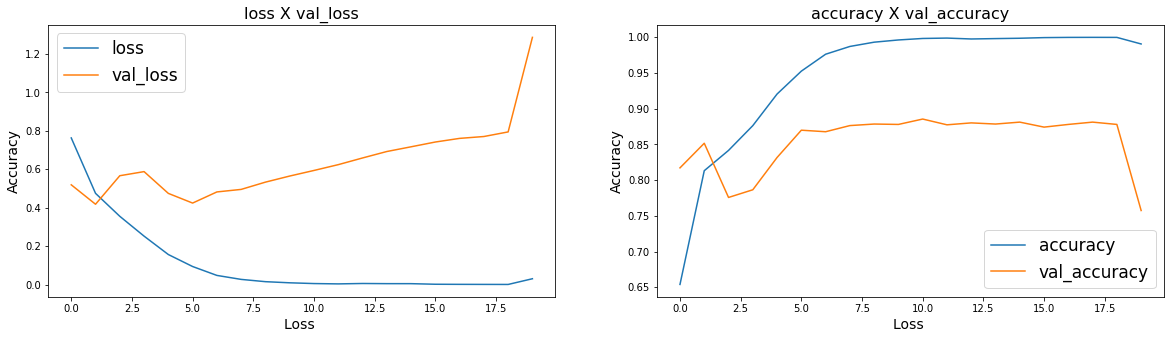

In [ ]:
#plotting graphs
plot_learning_curves(history2, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])
#predicting
pred2= np.argmax(model2.predict(X_test), axis=-1)
#printing reports
print(classification_report(y_test,pred2 ))
print(confusion_matrix(y_test, pred2))

In [ ]:
def MLP():
    model = Sequential()
    #embedding layer
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence))
    model.add(Flatten()) #flatten_layer
    model.add(Dense(512, activation='relu')) #dense_layer
    model.add(Dropout(0.2)) #dropout_layer
    model.add(Dense(3, activation = 'softmax'))#classification_layer
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

#building model
model3=MLP()

In [ ]:

#running_model
history3 = model3.fit(
    X_train,
    y_train,
    epochs = epoch_count,
    batch_size = batch_size,
    validation_data = (x_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr],
    class_weight=class_weight
)

Epoch 1/20
131/131 [==============================] - 13s 82ms/step - loss: 0.8979 - accuracy: 0.6052 - val_loss: 0.8987 - val_accuracy: 0.5573 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 5s 37ms/step - loss: 0.5179 - accuracy: 0.7931 - val_loss: 0.6330 - val_accuracy: 0.7547 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 5s 40ms/step - loss: 0.2595 - accuracy: 0.8864 - val_loss: 0.4816 - val_accuracy: 0.8386 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 3s 20ms/step - loss: 0.1252 - accuracy: 0.9455 - val_loss: 0.5158 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 5/20
131/131 [==============================] - 2s 18ms/step - loss: 0.0593 - accuracy: 0.9751 - val_loss: 0.5386 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 6/20
131/131 [==============================] - 2s 13ms/step - loss: 0.0311 - accuracy: 0.9884 - val_loss: 0.5503 - val_accuracy: 0.8714 - lr: 0.0010
Epoch 7/20
131/131 [==============================] - 2s 13ms/s

194/194 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.32      0.31      0.31       349
           1       0.92      0.91      0.92      4786
           2       0.75      0.80      0.77      1061

    accuracy                           0.86      6196
   macro avg       0.66      0.67      0.67      6196
weighted avg       0.86      0.86      0.86      6196

[[ 107  194   48]
 [ 184 4368  234]
 [  43  169  849]]


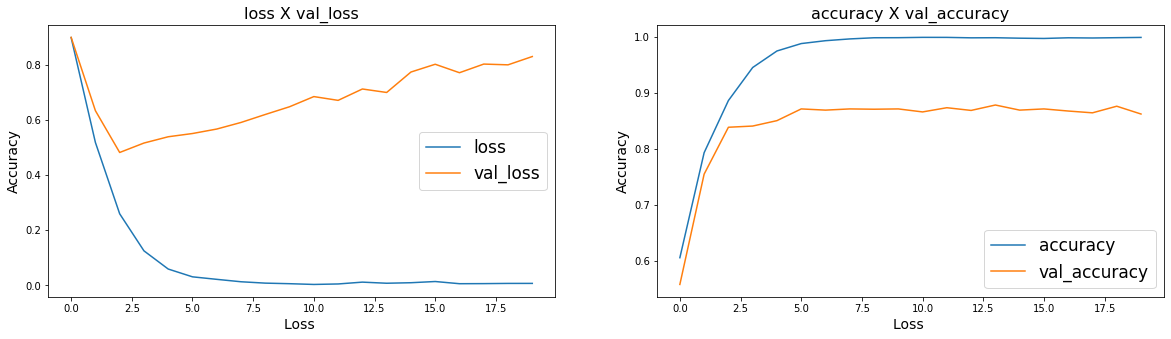

In [ ]:



#plotting_graphs
plot_learning_curves(history3, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])
#predicting
pred3= np.argmax(model3.predict(X_test), axis=-1)

print(classification_report(y_test,pred3))
print(confusion_matrix(y_test, pred3))